## BAYESIAN CLASSIFICATION using MULTIVARIATE GAUSSIAN MIXTURE MODELS
### CASE STUDY: Recognize VOWELS from FORMANTS


#### Reading Material
We make use of the Hillenbrand database.   The Hillebrand database contains average formant values measured over vowels.
For scatter plots and data exploration we refer to notebook ../lab03/FormantDistribution.ipynb or its corresponding output 
[FormantDistribution](https://compi1234.github.io/spchlab/Tutorials/FormantDistribution.html) 

#### Methods
We perform vowel classification based on a single observation (average formant values) as provided by the Hillenbrand database.
We use statistical machine learning techniques based on data modeling and Bayesian inference.
Classification requires usage of multiple formant features.  For the models we will use multi-D Gaussian distributions.


### 1. Setting up your Python Environment

In [1]:
####################################################################################
### This setting is to avoid memory leaks in sklearn KMEANS on windows+MKL machines 
### This must be executed before importing numpy (here or in other packages) 
import os
os.environ["OMP_NUM_THREADS"] = '2'  
import warnings
warnings.filterwarnings("ignore")
####################################################################################

In [2]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [3]:
# Importing Python's baseline machine learning stack 
#
%matplotlib inline
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.io as sio

# imports from the scikit-learn 
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import Perceptron
from sklearn import metrics as skmetrics
from sklearn.mixture import GaussianMixture

import pyspch.core as Spch
from pyspch.stats import GMM
from pyspch.core.hillenbrand import fetch_hillenbrand, select_hillenbrand

import pyspch.display as Spd   # sets some plotting preferences
colors = Spd.colors
markers = Spd.markers
cmap = sns.color_palette(colors)
sns.set_palette(cmap)
np.set_printoptions(precision=2)
mpl.rcParams['figure.figsize'] = [8.,7.]
mpl.rcParams['font.size'] = 11
#
# making a color - phoneme mapping and defining vowel subsets
table_order = ['iy','ih','eh','ae','aa','ao','uh','uw','ah','er','ey','ow']
vowel_order = ['iy','aa','uw','ih','eh','er','ah','ae','ao','uh','ey','ow']
vowel2color = dict(zip(vowel_order,colors))
color2vowel = dict(zip(colors,vowel_order))
vow12 = vowel_order
vow10 = vowel_order[0:10]
vow6 = vowel_order[0:6]
vow3 = vowel_order[0:3]

### 2. The Database 
All experiments in this notebook are using (parts of) the Hillenbrand '95 database. For detailed information and references: https://homes.esat.kuleuven.be/~spchlab/datasets/hillenbrand/README.txt

We grab only a selection of the database with the principle measurements that can be used to do vowel recognition from psychoacoustic measurements (3 formants, pitch, duration).  
We drop all records with missing data.

In [4]:
hildata = fetch_hillenbrand(columns=["gender","vowel","dur","f0","F1","F2","F3"],symbols="arpa").dropna()
print(hildata.head())

      gender vowel    dur     f0     F1      F2      F3
fid                                                    
m01ae      m    ae  323.0  174.0  663.0  2012.0  2659.0
m02ae      m    ae  250.0  102.0  628.0  1871.0  2477.0
m03ae      m    ae  344.0   99.0  605.0  1812.0  2570.0
m04ae      m    ae  312.0  124.0  627.0  1910.0  2488.0
m06ae      m    ae  254.0  115.0  647.0  1864.0  2561.0


### Data Exploration

We first explore if the five features (dur, f0, F1, F2 and F3) make sense and if we expect them to contribute all to a vowel classification task.
+ a scatter plot is a simple method for showing a 2D data distribution, i.e. when we have 2 features such as F1 and F2 for vowel recognition 
+ when the data gets slightly more high dimensional, we can make a gridplot containing a collection of scatter plots for a better overall view
+ for high dimensional data we barely can rely on visual representation, but we often make use of mathematical techniques to plot projected data in 2D   ( PCA, LDA, TSNE, ..  )

#### Tasks & Questions (1)
What do the scatter plots tell you?
   + Are there features that can be dropped if vowel classification is our goal ?
   + Which 2 features look most salient and must surely be retained ?
   + Try to rank the features in order of importance for this 10 vowel classification task

<Axes: xlabel='F1', ylabel='F2'>

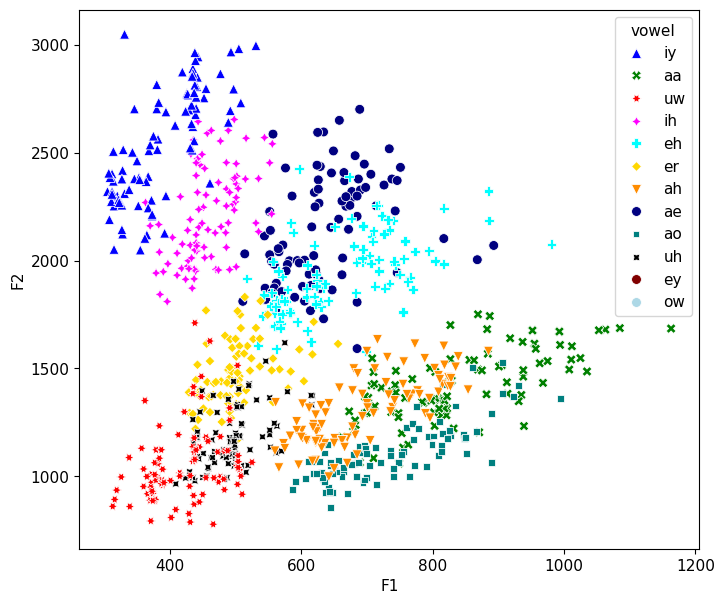

In [5]:
# a simple scatter plot with 2 selected features
# the categgories can be shown as hue(color) or style(marker)
# data is limited to the adult data
f=plt.figure() 
data = select_hillenbrand(hildata,genders='adults',vowels=vow10)
sns.scatterplot(x='F1',y='F2',data=data,hue="vowel",style="vowel",hue_order=vowel_order,s=50)

<Figure size 800x700 with 0 Axes>

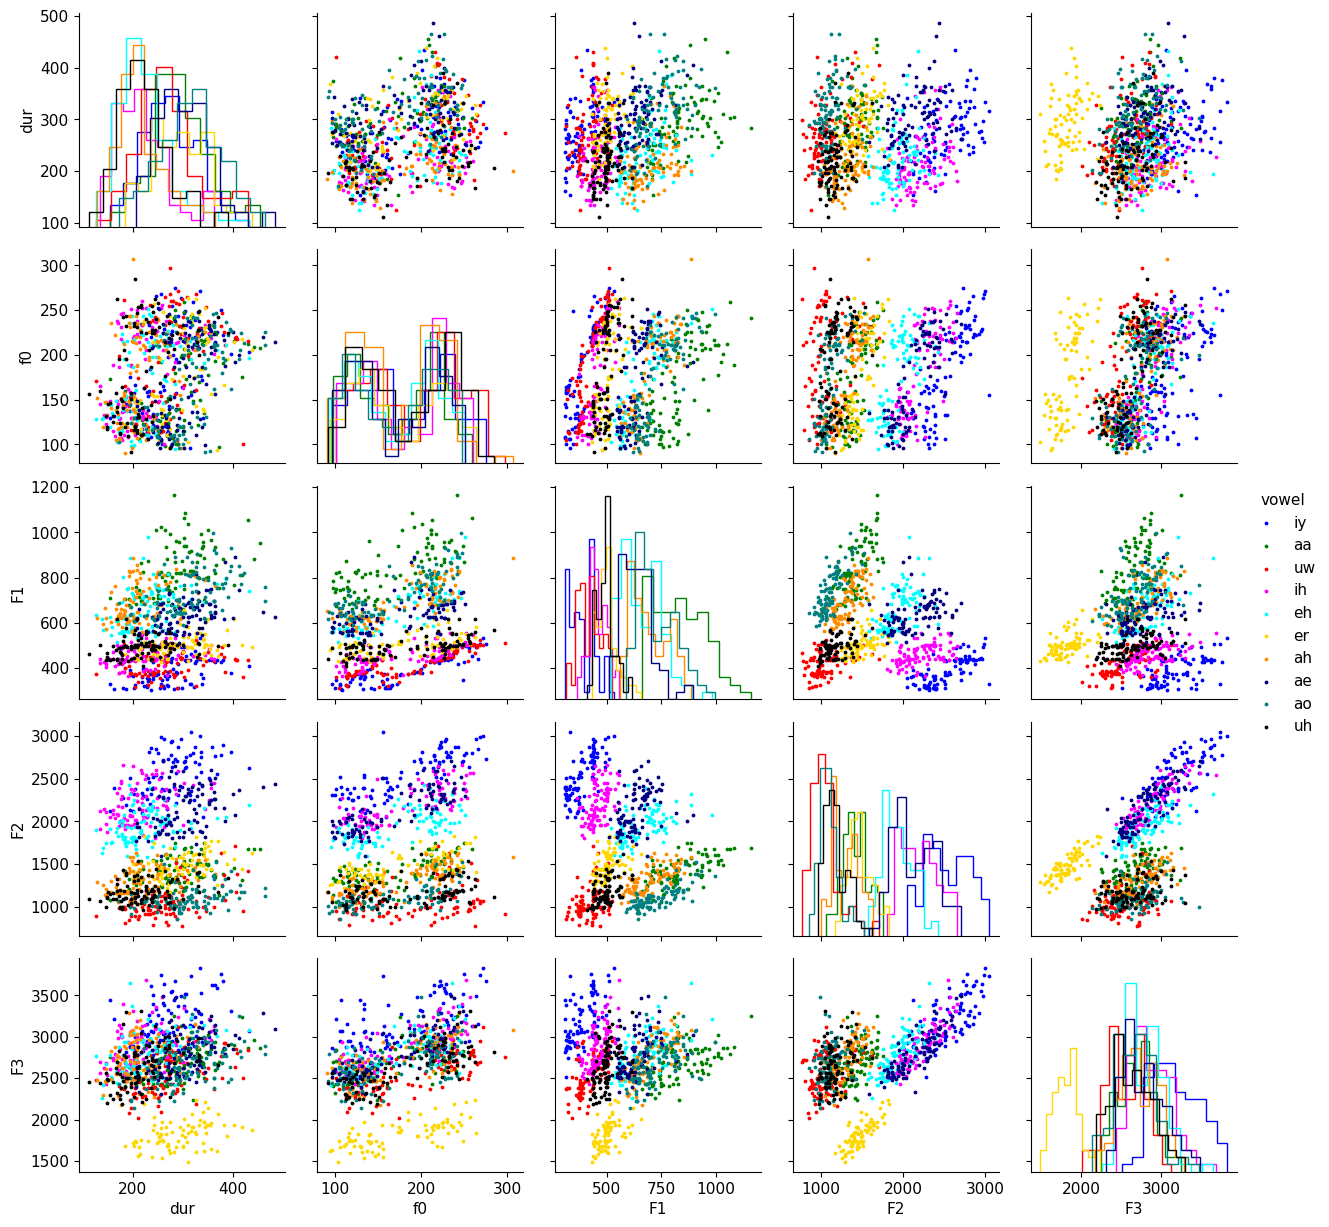

In [6]:
f=plt.figure()
g = sns.PairGrid(data,hue="vowel",hue_order=vow10)
g.map_diag(plt.hist,histtype="step", linewidth=1)
g.map_offdiag(plt.scatter,s=3)
g.add_legend()

### 3. Classification using a Bayesian classifier and Gaussian Mixture Models

By default we work with the 'vow10' subset, i.e. we try to recognize vowel from a set of 10.
If you want simpler tasks, use the predefined vow6 or vow3 subsets.

Performing a recognition experiments consist of following steps
1. SETUP: split the data in  training set and  test set
    -  X_train, y_train, X_test, y_test
2. TRAINING: train models in each class given the training data 
3. CLASSIFICATION: construct a classifier using the Bayesian rule and posteriors
4. EVALUATION: evaluate on test data;
   + look at overall score
   + look more in detail to a confusion matrix (next codeblock)

##### Implementation:   
We use the class *GMM* which is provided in the pyspch.stats package.
Its user interface is similar to all classifiers in *sklearn*, the GMM contains for each
class a GaussianMixture density estimator.  
During inference the likelihoods are combined with the estimated (or predefined) priors to compute the class posteriors

There are a number of parameters that you may adjust in the following code blocks
- covariance_type: type of convariance modeling ('diag', 'full' or 'spherical')
- n_components:  the number of mixtures used in the Gaussian MM
- train_size:    the proportion of the data that will be used for training, the remainder is used for testing
- priors_test:   you can override the class priors during testing
- random_state:  this number controls the random division between train and test set. You can modify this to see if different divisions lead to different results


##### Suggested Task & Questions (2)
1. Compare **diagonal** vs. **full** covariance modeling and the effect on classification accuracy.  Set n_components to 1 for this setup.
2. To evaluate **Gaussian Mixture Modeling**, set covariance_type to 'diag' (diagonal) and use n_components (number of gaussians) 1,2,4 or 8.
3. Evaluate the performance for different feature sets, [F1,F2] vs. [F1,F2,F3]
4. (optional) Go back and use a smaller database, just selecting the short vowels with 'vowels6' and do the same analysis
5. (optional) Go back and add 'dur' as a 4th feature.  Duration is a temporal feature and could be complementary to the formants that are spectral features.  Where in the confusion matrix could you hope for an improvement ? 

In [15]:
#####################################################################
# YOU CAN CHANGE THE FOLLOWING PARAMETERS TO DEFINE A NEW EXPERIMENT
#   The vowels define the classes
#   Select features from F1, F2, F3, dur, f0
#   Choose covariance_type 'full' or 'diag'
#   Select the number of components for GMM modeling
gender_selection = ['m','w'] # 'adults'
vowel_selection =  table_order[0:10]  # vow6, vo10, ..
feature_list = ['F1','F2','F3']
covariance_type = 'full'     
n_components = 1
######################################################################
#
#
data = select_hillenbrand(hildata,genders=gender_selection,vowels=vowel_selection)
classes = vowel_selection
X=np.array(data.loc[:,feature_list])
y=np.array(data.loc[:,'vowel'])
train_size=0.5
max_iter = 10      # maximum number of iterations in the EM algorithm
random_state = 0
priors_test = None # should be None or a vector
# --------------
# 1. select non-overlapping train and test sets
test_size=1.0 - train_size
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=test_size, random_state=random_state)
# 2. initialize and train the model
clf_GMM = GMM(classes=classes,n_components=n_components,max_iter=max_iter,covariance_type=covariance_type)
#clf_GMM.fit(X,y)
clf_GMM.fit(X_train,y_train)
# 3. print the model
# clf_GMM.print_model()

VOWELS:  ['iy', 'ih', 'eh', 'ae', 'aa', 'ao', 'uh', 'uw', 'ah', 'er']
FEATURES:  ['F1', 'F2', 'F3']
MODELING: full covariance Gaussian(1)

-------  TRAIN SET   --------
Accuracy: 85.46%



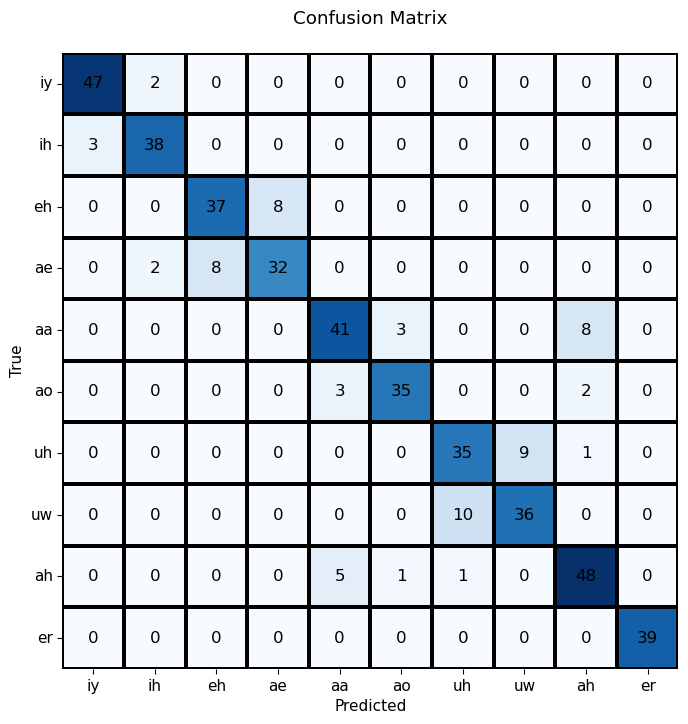


-------  TEST SET   --------
Accuracy: 81.54%



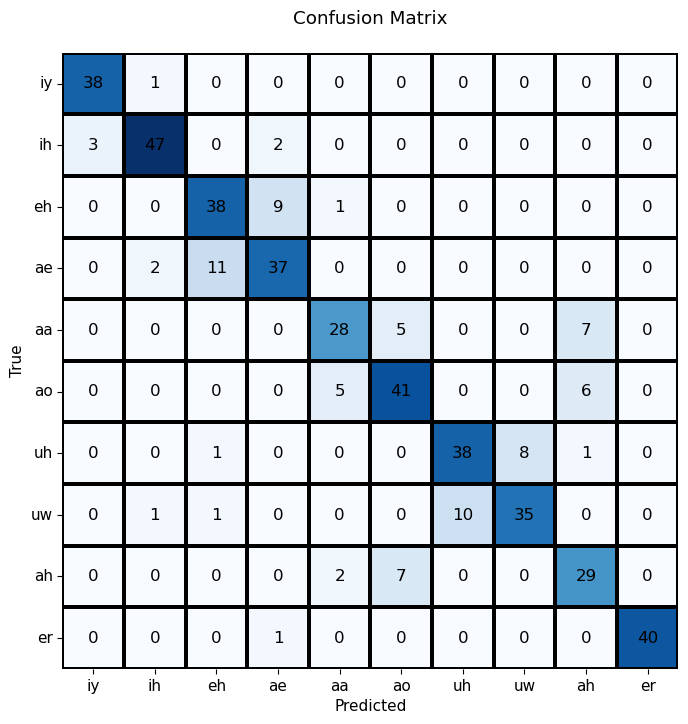

In [16]:
# 4. Evaluate
# Compute Global accuracy and confusion matrix both for train and test data
# A Confusion Matrix gives a more detailed image of the errors that we make
print("VOWELS: ",classes)
print("FEATURES: ",feature_list)
print("MODELING: %s covariance Gaussian(%d)" %(covariance_type,n_components))

for (SET, X_t,y_t) in zip( ("TRAIN","TEST"), (X_train,X_test), (y_train,y_test) ):
    #print("Evaluating on %s set" % SET)
    y_pred = clf_GMM.predict(X_t)
    cf_mat = skmetrics.confusion_matrix(y_t,y_pred,labels=classes)    
    print("\n-------  %s SET   --------" % SET)
    print('Accuracy: %.2f%%\n' % (100.0*skmetrics.accuracy_score(y_t, y_pred)))
    Spch.plot_confusion_matrix(cf_mat,labels=classes,figsize=(8,8));

In [24]:
## Test on your personal measurements
#### ENTER HERE YOUR VALUES ####
# For the example 'female2.wav' we obtained following rough estimates for the formant values:
# t=1.78:   900, 1600, 3200
# t=2.45:   400, 1600, 2700
# t=3.40:   500, 1900, 2800
#
X_new = np.asarray([ [ 900., 1600., 3200.], [400., 1600., 2700.], [500., 1900., 2800.] ])
########################################
y_new = clf_GMM.predict(X_new)
y_prob = clf_GMM.predict_proba(X_new)
print("Classes: ",clf_GMM.classes)
print("  Features - Recognized - Probabilities(in%)  ")
for XX,yy,yp in zip(X_new,y_new,y_prob):
    print(XX,yy,(yp*100).astype('int') )

Classes:  ['iy', 'ih', 'eh', 'ae', 'aa', 'ao', 'uh', 'uw', 'ah', 'er']
  Features - Recognized - Probabilities(in%)  
[ 900. 1600. 3200.] ah [ 0  0  0  0  3  0  0  0 96  0]
[ 400. 1600. 2700.] uw [ 0  3 35  0  0  0  0 60  0  0]
[ 500. 1900. 2800.] ih [ 0 63 31  4  0  0  0  0  0  0]


### CROSS VALIDATION

WARNING: RESULTS are not as expected, so probably there is some glitch in the implementation    

Doing Cross Validation implies splitting the data into K similar splits, then training on K-1 splits and testing on the remainder 1
and this repeated K times.
Making K splits requires scrutiny.  In our database data comes not in random order: it is a sequential in vowel ID, then gender, then speaker ID.
In order to make that each split is well balanced for gender and speakers it is best to shuffle the data.   
Note1: that the defaults in sklearn selects blocks of data, which would inherently lead to bad subdivisions.   
Note2: You could (probably should) approach the train/test splitting even differently.  To have fully unbiased result train set speakers should not appear in the test set.
Hence creating the splits should work on speakers, rather than on samples.   This is not implemented below.   

#### Tasks & Questions
Given that this is rather limited database, we may prefer a cross_validation style evaluation.   
Change the number of folds in the crossvalidation between 2, 5 and 10.  Is there a trend to be observed ?

In [13]:
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
n_components = 1
covariance_type = 'full'
nfold_options = [2,4,8] # [5,10,2]
ftr_options = [ ['F1','F2','F3' ] ] #, ['F1','F2'], ['F2','F3'], ['F2'] , ['F1'] ]
for ftrs in ftr_options:
    print('Features: ',ftrs)
    X=np.array(data.loc[:,ftrs])
    clf_GMM = GMM(classes=classes,n_components=n_components,max_iter=20,covariance_type=covariance_type)        
    clf_GMM.fit(X,y)
    y_pred = clf_GMM.predict(X,priors=priors_test)
    print('Accuracy for train/test(all): %.2f%%' % (100.0*skmetrics.accuracy_score(y , y_pred)))
    for nfolds in nfold_options:
        clf_GMM = GMM(classes=classes,n_components=n_components,max_iter=20,covariance_type=covariance_type)        
        scores = cross_val_score(clf_GMM, X, y, cv=StratifiedKFold(n_splits=nfolds,  shuffle=True, random_state=1) )
        #scores = cross_val_score(clf_GMM, X, y, cv=StratifiedGroupKFold(n_splits=3), groups=data['gender'].tolist())      
        print(scores)
        print("Average Cross validation score for %d folds: %.2f %% correct" % (nfolds,100.0*np.average(scores)))
        #y_pred = cross_val_predict(clf_GMM, X, y, cv=nfolds,verbose=0)
        #for (y_,X_,pred_) in zip(y,X,y_pred):
            #print(y_,X_,pred_)

Features:  ['F1', 'F2', 'F3']
Accuracy for train/test(all): 84.16%
[0.75 0.74]
Average Cross validation score for 2 folds: 74.59 % correct
[0.75 0.71 0.72 0.78]
Average Cross validation score for 4 folds: 74.26 % correct
[0.77 0.77 0.71 0.68 0.74 0.73 0.78 0.73]
Average Cross validation score for 8 folds: 73.93 % correct
